In [1]:
import sys
gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(gems_tco_path)

from collections import defaultdict
# Data manipulation and analysis
import pandas as pd
import numpy as np
import pickle
import torch

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Nearest neighbor search
import sklearn
from sklearn.neighbors import BallTree

# Custom imports

from GEMS_TCO import orbitmap 
from GEMS_TCO import kernels 
from GEMS_TCO import evaluate
from GEMS_TCO import orderings as _orderings
from GEMS_TCO import load_data_local_computer
import os
from collections import deque

### Quick import empirical semi-variogram from amarel

In [ ]:
input_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/GEMS_TCO_EDA/outputs"
input_filename = "empirical_sem_1250_july24.pkl"
    
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    emp_sem1250= pickle.load(pickle_file)

input_filename = "empirical_short_sem_5000_july24.pkl"
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    emp_sem5000= pickle.load(pickle_file) 

In [ ]:
aggregated_sem ={}
for key in emp_sem5000:
    tmp =emp_sem1250[key]
    tmp = [x.item() if isinstance(x, torch.Tensor) else x for x in tmp]
    tmp = deque(tmp)
    tmp.appendleft(emp_sem5000[key].item())
    aggregated_sem[key] = tmp 

### Save daily semivariogram plots

In [ ]:
colors = plt.cm.viridis(np.linspace(0, 1, 8))  # Color map for the temporal lags
plt.figure(figsize=(10, 6))
for i in range(1,32):
    for temporal_lag in range(8): 
        plt.plot( aggregated_sem[i,temporal_lag,0], aggregated_sem[i,temporal_lag,1], color=colors[temporal_lag], label=f'Temporal Lag {temporal_lag}')

    plt.xlabel("latitude, longitude distance h")
    plt.ylabel('Semivariogram γ(h)')
    plt.ylim(0, 30)
    plt.xlim(0,3)
    plt.title(f'Empirical Semivariogram 07-{i:02d}-24')
    plt.legend()
    
    # Save the plot to a specific location
    plt.savefig(f'/Users/joonwonlee/Documents/GEMS_TCO-1/plots/emp_sem_july24/1250_07-{i:02d}-24.png')
    plt.close()  # Close the plot to avoid overlapping plots

    # plt.show()

### Save 5 days averageg semivariograms  

In [5]:
for i in range(1,31,5):
    for temporal_lag in range(8): 

        avg_sem = np.mean([aggregated_sem[i, temporal_lag, 1], 
                           aggregated_sem[i+1, temporal_lag, 1], 
                           aggregated_sem[i+2, temporal_lag, 1], 
                           aggregated_sem[i+3, temporal_lag, 1], 
                           aggregated_sem[i+4, temporal_lag, 1]], axis=0)
        #print(avg_sem)

        plt.plot( aggregated_sem[i,temporal_lag,0], avg_sem, color=colors[temporal_lag], label=f'Temporal Lag {temporal_lag}')

    plt.xlabel("latitude, longitude distance h")
    plt.ylabel('Semivariogram γ(h)')
    plt.ylim(0, 30)
    plt.xlim(0,3)
    plt.title(f'Averaged Semivariogram from 07-{i:02d} to 07-{i+4:02d}-24')
    plt.legend()
    # Save the plot to a specific location
    plt.savefig(f'/Users/joonwonlee/Documents/GEMS_TCO-1/plots/avg5_sem_july24/1250_07-{i:02d} (2024).png')
    plt.close()  # Close the plot to avoid overlapping plots

    plt.show()

### Save empirical and theoretical semivariograms together 

In [6]:
input_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/Exercises/st_model/estimates"

# input_filename = "estimation_50_july24.pkl"
# input_filename = "estimation_200_july24.pkl"
input_filename = "full_estimation_1250_july24.pkl"
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    amarel_map1250= pickle.load(pickle_file)

# Assuming df_1250 is your DataFrame
df_1250 = pd.DataFrame()
for key in amarel_map1250:
    tmp = pd.DataFrame(amarel_map1250[key][0].reshape(1, -1), columns=['sigmasq', 'range_lat', 'range_lon', 'advec_lat', 'advec_lon', 'beta', 'nugget'])
    tmp['loss'] = amarel_map1250[key][1]
    df_1250 = pd.concat((df_1250, tmp), axis=0)

# Generate date range
date_range = pd.date_range(start='07-01-24', end='07-31-24')

# Ensure the number of dates matches the number of rows in df_1250
if len(date_range) == len(df_1250):
    df_1250.index = date_range
else:
    print("The number of dates does not match the number of rows in the DataFrame.")


print(df_1250)


              sigmasq  range_lat  range_lon  advec_lat  advec_lon      beta  \
2024-07-01  24.793444   1.584529   1.718248   0.009089  -0.107299  0.131038   
2024-07-02  24.424301   1.997055   1.942683   0.043588  -0.072679  0.137124   
2024-07-03  26.009497   1.215236   1.558868   0.023392  -0.150548  0.199850   
2024-07-04  24.701347   1.612308   1.822960  -0.164069  -0.237443  0.131595   
2024-07-05  22.598671   2.901185   3.722327  -0.011729  -0.152072  0.072866   
2024-07-06  25.594908   1.702692   2.255174   0.017462  -0.158125  0.098684   
2024-07-07  26.030510   1.261084   2.831952   0.054831  -0.343255  0.103045   
2024-07-08  26.043682   0.995279   1.629503  -0.019824  -0.411626  0.164296   
2024-07-09  24.052071   1.377774   2.357721   0.021439  -0.220316  0.142847   
2024-07-10  25.766109   1.392051   2.358171   0.026684  -0.077366  0.150648   
2024-07-11  23.945438   1.490333   2.470762  -0.009915   0.027429  0.137959   
2024-07-12  23.036034   2.299998   3.346955  -0.0542

In [7]:
params = [24, 1.2,1.6, 0.0008, -0.12, 0.12, 3.49]
params = [20, 10, 10, 0.01, 0.5, 0.3/5, 4]
params = [24, 1.6, 2, 0.06, -0.15, 0.13, 3.49]

def theoretical_gamma_ani_st(params, lat_diff, lon_diff, time_diff):
    # Unpack parameters
    sigmasq, range_lat, range_lon, advec_lat, advec_lon, beta, nugget = params
    
    # Calculate the spatial-temporal differences
    tmp1 = lat_diff - advec_lat * time_diff
    tmp2 = lon_diff - advec_lon * time_diff
    tmp3 = beta * time_diff
    
    d = tmp1**2/range_lat**2 + tmp2**2/range_lon**2 + tmp3**2
    
    # Convert d into a tensor (if it's not already) and compute the semivariogram
    # d = d.clone().detach()

    out = nugget + sigmasq * (1 - np.exp(- np.sqrt(d) ) )
    
    return np.sqrt(d), out

for i in range(1,31,5):
    for temporal_lag in range(8): 

        avg_sem = np.mean([aggregated_sem[i, temporal_lag, 1], 
                           aggregated_sem[i+1, temporal_lag, 1], 
                           aggregated_sem[i+2, temporal_lag, 1], 
                           aggregated_sem[i+3, temporal_lag, 1], 
                           aggregated_sem[i+4, temporal_lag, 1]], axis=0)
        #print(avg_sem)
        theory = [0] * len(aggregated_sem[i, temporal_lag, 0])
        for j in range(len(aggregated_sem[i, temporal_lag, 0])):
            lag = aggregated_sem[i, temporal_lag, 0][j]
            _, theory[j] = theoretical_gamma_ani_st(params, lag, lag, temporal_lag)

        plt.plot(aggregated_sem[i, temporal_lag, 0], avg_sem, color=colors[temporal_lag], linestyle='-', label=f'Temporal Lag {temporal_lag} (Emp)')
        plt.plot(aggregated_sem[i, temporal_lag, 0], theory, color=colors[temporal_lag], linestyle=':', label=f'Temporal Lag {temporal_lag} (Theory)')

    plt.xlabel("latitude, longitude distance h")
    plt.ylabel('Semivariogram γ(h)')
    plt.ylim(0, 40)
    plt.xlim(0, 3)
    plt.title(f'Averaged emp and the semivariograms from 07-{i:02d} to 07-{i+4:02d} (2024)')

    # Save the plot to a specific location
    plt.savefig(f'/Users/joonwonlee/Documents/GEMS_TCO-1/plots/avg5_emp_the_july24/1250_07-{i:02d}_to_07-{i+4:02d} (2024).png')
    plt.close()  # Close the plot to avoid overlapping plots
    # plt.legend(fontsize='small')

    plt.show()


# load data

In [ ]:
lat_lon_resolution = [1,1]
mm_cond_number = 20
years = ['2024']
month_range =[7,8]
idx_for_datamap= [0,8]

params= [20, 8.25, 5.25, 0.2, 0.5, 5]

instance = load_data_local_computer()
map, ord_mm, nns_map= instance.load_mm20k_data_bymonthyear( lat_lon_resolution= lat_lon_resolution, mm_cond_number=mm_cond_number,years_=years, months_=month_range)

analysis_data_map, aggregated_data = instance.load_working_data_byday( map, ord_mm, nns_map, idx_for_datamap=[0,8])


Theoretical semivariograms for thee models:

1. anisotropic in latitude, longitude, time
2. isotropic in space but not in time
3. isotropic in latitude, longitude, and time

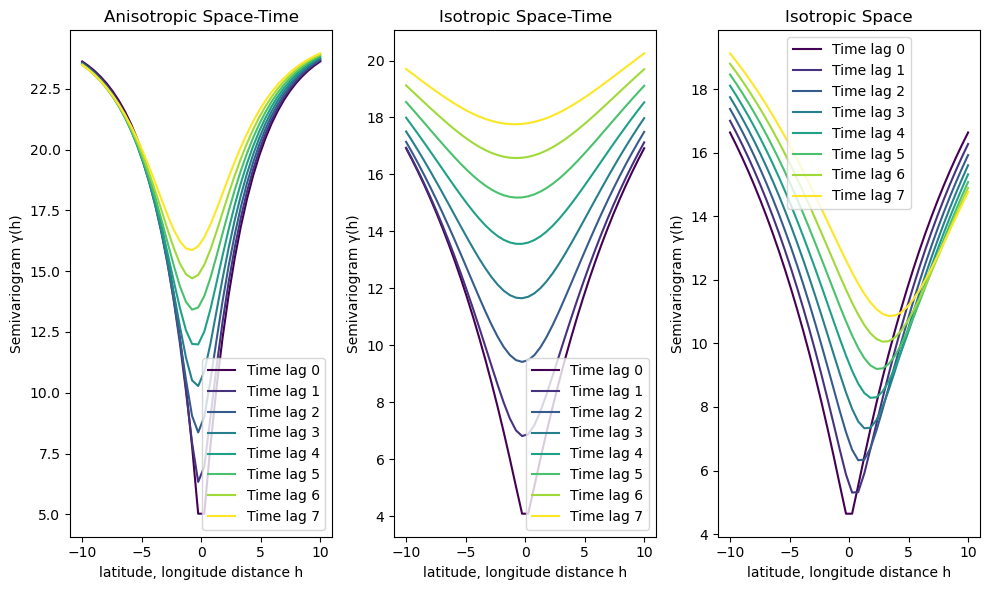

In [2]:
def theoretical_gamma_ani_st(params, lat_diff, lon_diff, time_diff):
    # Unpack parameters
    sigmasq, range_lat, range_lon, advec_lat, advec_lon, beta, nugget = params
    
    # Calculate the spatial-temporal differences
    tmp1 = lat_diff - advec_lat * time_diff
    tmp2 = lon_diff - advec_lon * time_diff
    tmp3 = beta * time_diff
    
    d = tmp1**2/range_lat**2 + tmp2**2/range_lon**2 + tmp3**2
    
    # Convert d into a tensor (if it's not already) and compute the semivariogram
    d = d.clone().detach()

    out = nugget + sigmasq * (1 - torch.exp(- torch.sqrt(d) ) )
    
    return torch.sqrt(d), out

def theoretical_gamma_iso_space(params, lat_diff, lon_diff, time_diff):
    # Unpack parameters
    sigmasq, range_, _, advec_lat, advec_lon, beta, nugget = params
    
    # Calculate the spatial-temporal differences
    tmp1 = lat_diff - advec_lat * time_diff
    tmp2 = lon_diff - advec_lon * time_diff
    tmp3 = beta * time_diff
    
    d = (tmp1**2+ tmp2**2)/range_**2 + tmp3**2
    
    # Convert d into a tensor (if it's not already) and compute the semivariogram
    d = d.clone().detach()

    out = nugget + sigmasq * (1 - torch.exp(- torch.sqrt(d)) )
    
    return torch.sqrt(d), out

def theoretical_gamma_iso_st(params, lat_diff, lon_diff, time_diff):
    # Unpack parameters
    sigmasq, range_, _, advec_lat, advec_lon, _, nugget = params
    
    # Calculate the spatial-temporal differences
    tmp1 = lat_diff - advec_lat * time_diff
    tmp2 = lon_diff - advec_lon * time_diff
    tmp3 = 1 * time_diff
    
    d = tmp1**2+ tmp2**2 + tmp3**2
    
    # Convert d into a tensor (if it's not already) and compute the semivariogram
    d = d.clone().detach()

    out = nugget + sigmasq * (1 - torch.exp(- torch.sqrt(d)/range_ ) )
    
    return torch.sqrt(d), out


def plot_theoretical_semivariogram(params, deltas, time_lags, gamma_fun, ax):
    # Create a plot with different colors for each time difference
    colors = plt.cm.viridis(np.linspace(0, 1, len(time_lags)))  # Color map for different time lags
    
    for t in range(8):
        gamma_values = []
        d_values = []
        for delta in deltas:
            # Calculate theoretical semivariogram for this distance and time lag
            d, gamma = gamma_fun(params, 0.2, delta, time_lags[t])  # lat_diff = lon_diff = delta, time_diff = t
            
            gamma_values.append(gamma.item())  # Convert tensor to scalar for plotting
            d_values.append(d.item())
       
        # Plot the semivariogram for the current time lag
        ax.plot(deltas.numpy(), gamma_values, label=f"Time lag {time_lags[t]}", color=colors[t])
        
    ax.set_xlabel("latitude, longitude distance h")
    ax.set_ylabel("Semivariogram γ(h)")
    ax.legend()

# Example parameters (sigmasq, range, range_lon, advec_lat, advec_lon, beta, nugget)
params = [20, 10, 5, 0.5, 0.5, 0.3, 4]
params = [27.0996, 1.7303, 1.8876, 8.413e-3, -0.1029, 0.1219, 2.73]
params = [21.28, 9.92, 3.335, -1.2099, -0.1238,-0.0151, 3.4034]
# Define deltas for distance bins
deltas = torch.linspace(-10,10, 40)

# Define the time lags you want to plot
time_lags = [0,1,2,3,4,5,6,7]

# Create a figure with 3 subplots in one row
fig, axs = plt.subplots(1,3, figsize=(10,6))

# Plot the theoretical semivariogram for the specified time lags in each subplot
plot_theoretical_semivariogram(params, deltas, time_lags, theoretical_gamma_ani_st, axs[0])
axs[0].set_title("Anisotropic Space-Time")

plot_theoretical_semivariogram(params, deltas, time_lags, theoretical_gamma_iso_st, axs[1])
axs[1].set_title("Isotropic Space-Time")

params = [21.28, 9.92, 3.335, -1.2099, -0.1238,-0.0151, 3.4034]

params = [27.0996, 1.7303, 1.8876, 8.413e-3, -0.1029, 0.1219, 2.73]
params = [20, 10, 5, 0.01, 0.5, 0.3/5, 4]


plot_theoretical_semivariogram(params, deltas, time_lags, theoretical_gamma_iso_space, axs[2])
axs[2].set_title("Isotropic Space")


plt.tight_layout()
plt.show()


different resolution anisotropy model

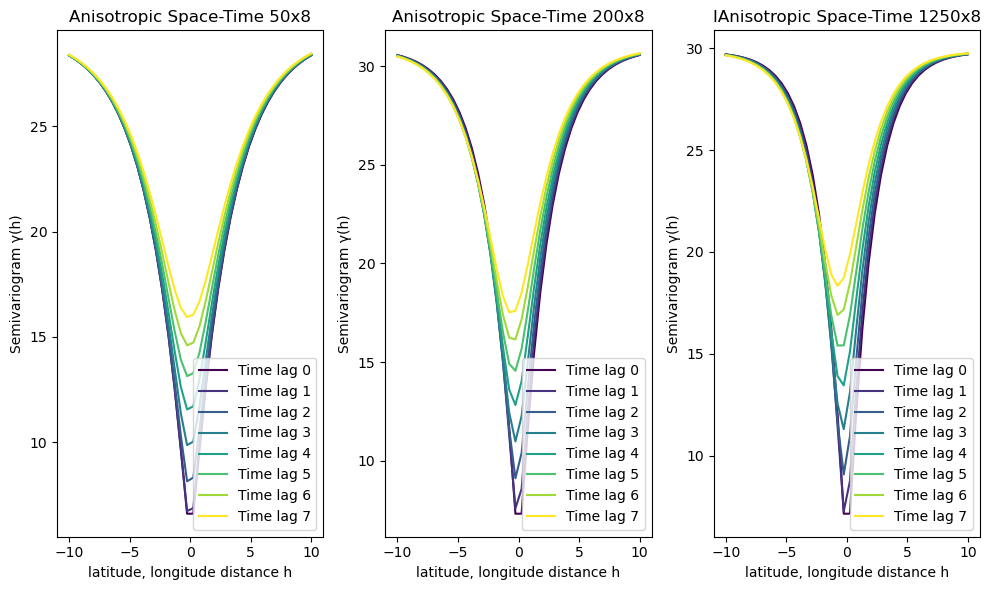

In [10]:
# Define deltas for distance bins
deltas = torch.linspace(-10,10, 40)
# Define the time lags you want to plot
time_lags = [0,1,2,3,4,5,6,7]

# Create a figure with 3 subplots in one row
fig, axs = plt.subplots(1,3, figsize=(10,6))
params = [25.6506, 2.38, 3.107, 0.1022, -0.0147, 0.0865, 3.75]
# Plot the theoretical semivariogram for the specified time lags in each subplot
plot_theoretical_semivariogram(params, deltas, time_lags, theoretical_gamma_ani_st, axs[0])
axs[0].set_title("Anisotropic Space-Time 50x8")


params = [27.2565, 2.18, 2.294, 4.099e-4, -7.915e-2, 0.0999, 3.65]
plot_theoretical_semivariogram(params, deltas, time_lags, theoretical_gamma_ani_st, axs[1])
axs[1].set_title("Anisotropic Space-Time 200x8")


params = [27.0996, 1.7303, 1.8876, 8.413e-3, -0.1029, 0.1219, 2.73]
plot_theoretical_semivariogram(params, deltas, time_lags, theoretical_gamma_ani_st, axs[2])
axs[2].set_title("IAnisotropic Space-Time 1250x8")


plt.tight_layout()
plt.show()

It seems a model isotropic in space but not in time best describe the data

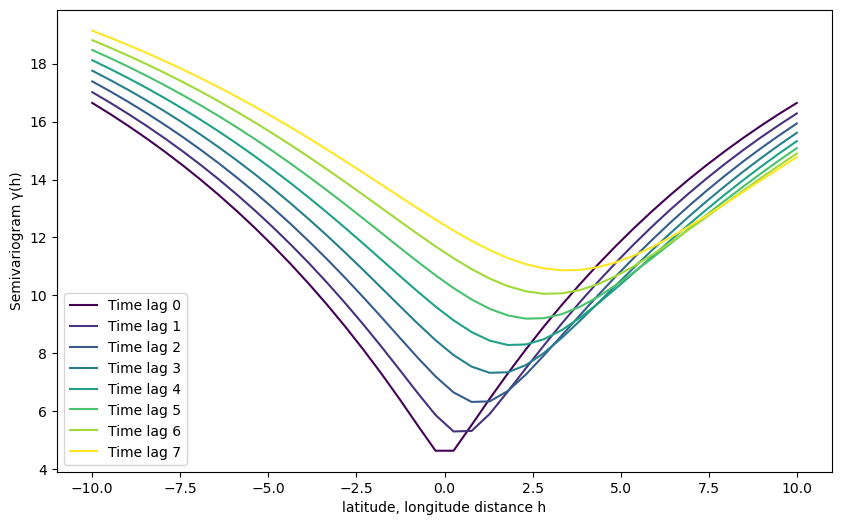

In [40]:

params = [20, 10, 10, 0.01, 0.5, 0.3/5, 4]


# Create a figure with 3 subplots in one row
fig, axs = plt.subplots(1,1, figsize=(10,6))
plot_theoretical_semivariogram(params, deltas, time_lags, theoretical_gamma_iso_space, axs)

time_lags = [1, 2, 3, 4, 5, 6, 7]
# deltas = torch.linspace(-10,10, 40)




Empirical semivariogram using real data

In [17]:

def empirical_semivariogram(data, deltas ,tolerance, temporal_lag):
    # Extract data columns: latitude, longitude, time, values
    lat = data[:, 0]
    lon = data[:, 1]
    time = data[:, 3]
    values = data[:, 2]  # Assuming the values are in the 3rd column

    # Demean the values
    values = values - torch.mean(values)

    # Calculate spatial and temporal distances
    spatial_distances = torch.sqrt((lat.unsqueeze(1) - lat.unsqueeze(0))**2 + (lon.unsqueeze(1) - lon.unsqueeze(0))**2)
    temporal_distances = torch.abs(time.unsqueeze(1) - time.unsqueeze(0))


        # Calculate spatial and temporal distances
    lat_distances = lat.unsqueeze(1) - lat.unsqueeze(0)
    lon_distances = lon.unsqueeze(1) - lon.unsqueeze(0)

    empirical_sem = torch.zeros(len(deltas))
    
    # Calculate the semivariogram for each delta value
    for i, delta in enumerate(deltas):
        # Mask for spatial distances within the delta range and specific temporal lag
        mask = (torch.abs(lat_distances - delta) <= tolerance) & \
               (torch.abs(lon_distances - delta) <= tolerance) & \
               (temporal_distances == temporal_lag)
        
        if torch.any(mask):
            # Calculate semivariogram using squared differences of values
            differences = torch.abs(values.unsqueeze(1) - values.unsqueeze(0))
            empirical_sem[i] = 0.5 * torch.mean(differences[mask]**2)

    # Calculate the sill (variance of the values within the given temporal lag)

    
    # Create bins (spatial distances) from the deltas (you can adjust as needed)

    return deltas, empirical_sem


tolerance = 0.001

# Define deltas for distance bins
deltas = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.1, 1.3, 1.7, 2.0, 2.2, 2.5, 3.0, 3.2,3.3,3.4,3.5, 4.0,4.1, 4.2, 4.3,4.4,4.5, 5.1,5.2,5.36,6.1,6.05,6.15,6.2,6.25,6.3,6.35,7.05,7.1,8.05,8])
deltas = torch.cat((torch.linspace(0.1, 0.9, 9), torch.linspace(1.1, 2.5, 7)), dim=0)
deltas = torch.linspace(0.1,2.5,25)

deltas = torch.linspace(0.02, 0.02, 1)
colors = plt.cm.viridis(np.linspace(0, 1, 8))  # Color map for the temporal lags

data = aggregated_data
# Plot the empirical and theoretical semivariogram for different temporal lags
plt.figure(figsize=(10, 6))


map = defaultdict(list)
for temporal_lag in range(8): 
    deltas, empirical_sem= empirical_semivariogram(data, deltas,tolerance, temporal_lag)
    
    mask = empirical_sem!=0
    
    deltas_copy = deltas[mask].clone().detach()
    # print(deltas_copy)
    emp_st_sem = empirical_sem[mask].clone().detach()
    map[(1, temporal_lag,0)] = deltas_copy
    map[(1, temporal_lag,1)] =  emp_st_sem
    
    plt.plot( deltas_copy, emp_st_sem, color=colors[temporal_lag], label=f'Temporal Lag {temporal_lag}')

plt.xlabel("latitude, longitude distance h")
plt.ylabel('Semivariogram γ(h)')
plt.ylim(0, 18)
plt.xlim(0,3)
plt.title('Empirical Semivariogram')
plt.legend()
plt.show()


map

: 

Now empirical semivariogram for latitude slice

torch.Size([25])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])
torch.Size([5])


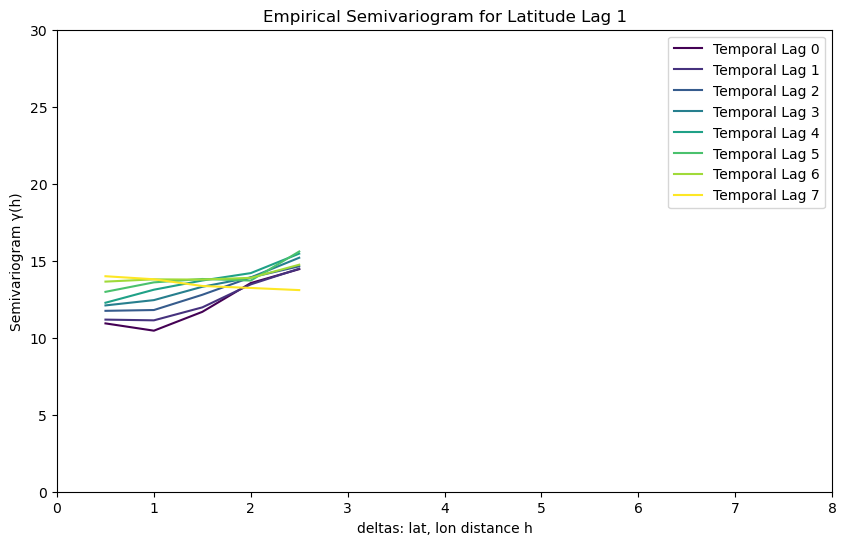

In [30]:
tolerance = 0.01
def empirical_semivariogram_slice(params, data, deltas ,tolerance, latitude_lag,temporal_lag):
    # Extract data columns: latitude, longitude, time, values
    lat = data[:, 0]
    lon = data[:, 1]
    time = data[:, 3]
    values = data[:, 2]  # Assuming the values are in the 3rd column

    # Calculate spatial and temporal distances
    lat_distances = lat.unsqueeze(1) - lat.unsqueeze(0)
    lon_distances = lon.unsqueeze(1) - lon.unsqueeze(0)
    temporal_distances = torch.abs(time.unsqueeze(1) - time.unsqueeze(0))
    
    
    empirical_sem = torch.zeros(len(deltas))
    
    
    # Calculate the semivariogram for each delta value
    for i in range(len(deltas)):
        # Mask for spatial distances within the delta range and specific temporal lag
        mask = (torch.abs(lat_distances - latitude_lag) <= tolerance) & \
               (torch.abs(lon_distances - deltas[i]) <= tolerance) & \
               (temporal_distances == temporal_lag)
        if torch.any(mask):
            # Calculate semivariogram using squared differences of values
            differences = torch.abs(values.unsqueeze(1) - values.unsqueeze(0))
            empirical_sem[i] = 0.5 * torch.mean(differences[mask]**2)

    # Calculate the sill (variance of the values within the given temporal lag)

    
    # Create bins (spatial distances) from the deltas (you can adjust as needed)

    return deltas, empirical_sem

# Define deltas for distance bins
deltas = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.1, 1.3, 1.7, 2.0, 2.2, 2.5, 3.0, 4.0,5,6,8, 10, 12])
deltas = torch.linspace(0.1,2.5, 25)
colors = plt.cm.viridis(np.linspace(0, 1, 8))  # Color map for the temporal lags

data = aggregated_data
# Plot the empirical and theoretical semivariogram for different temporal lags
plt.figure(figsize=(10, 6))

latitude_lag = 1

for temporal_lag in range(8): 
    deltas, empirical_sem= empirical_semivariogram_slice(params, data, deltas,tolerance, latitude_lag,  temporal_lag)
    mask = empirical_sem!=0
    print(mask.shape)
    deltas = deltas[mask]
    
    tempirical_sem = empirical_sem[mask]
    
    plt.plot( deltas.clone().detach(), tempirical_sem.clone().detach(), color=colors[temporal_lag], label=f'Temporal Lag {temporal_lag}')

plt.xlabel('deltas: lat, lon distance h')
plt.ylabel('Semivariogram γ(h)')
plt.xlim(0,8)
plt.ylim(0, 30)
plt.title(f'Empirical Semivariogram for Latitude Lag {latitude_lag}')
plt.legend()
plt.show()

Simulate data and see the empirical semivariogram

In [97]:
params= torch.tensor([20, 8.25, 8.25, 0.2, 0.2, 0.5, 5 ])
# params= torch.tensor([20, 8.25,8.25, 0.2 , 0.2, 1, 5 ])
params = [27.0996, 1.7303, 1.8876, 8.413e-3, -0.1029, 0.1219, 2.73]
params = [20, 5, 5, 0.5, 0.5, 0.3/5, 4]
# Define the Matern covariance function

def matern_cov_iso_st(params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec_lat, advec_lon, _, nugget = params
    
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack(( (x1 - advec_lat * t1), (y1 - advec_lon * t1)), dim=-1)
    spat_coord2 = torch.stack(( (x2 - advec_lat * t2), (y2 - advec_lon * t2)), dim=-1)

    coords1 = torch.cat((spat_coord1, (1 * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (1 * t2).reshape(-1, 1)), dim=1)

    U = coords1
    V = coords2 
 
    diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
    spatial_diff = torch.norm(diff, dim=2)
    temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
    distance = ( spatial_diff**2 + temporal_diff**2 )

    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = sigmasq * torch.exp(- torch.sqrt(distance[non_zero_indices])/range_)
    out[~non_zero_indices] = sigmasq

    # Add a small jitter term to the diagonal for numerical stability
    out += torch.eye(out.shape[0]) * nugget

    return out

# iso in space but not in time
def matern_cov_iso_space(params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range1, range2, advec_lat, advec_lon, beta, nugget = params
    
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack(( (x1 - advec_lat * t1), (y1 - advec_lon * t1)), dim=-1)
    spat_coord2 = torch.stack(( (x2 - advec_lat * t2), (y2 - advec_lon * t2)), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    U = coords1
    V = coords2 
 
    diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
    spatial_diff = torch.norm(diff, dim=2)
    temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
    distance = (spatial_diff**2/range1**2 + temporal_diff**2)

    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = sigmasq * torch.exp(- torch.sqrt(distance[non_zero_indices]))
    out[~non_zero_indices] = sigmasq

    # Add a small jitter term to the diagonal for numerical stability
    out += torch.eye(out.shape[0]) * nugget

    return out

# anisotropic in three 
def matern_cov_ani(params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_lat, range_lon, advec_lat, advec_lon, beta, nugget = params
    
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack(( (x1 - advec_lat * t1)/range_lat, (y1 - advec_lon * t1)/range_lon), dim=-1)
    spat_coord2 = torch.stack(( (x2 - advec_lat * t2)/range_lat, (y2 - advec_lon * t2)/range_lon), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    U = coords1
    V = coords2 
 
    diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
    spatial_diff = torch.norm(diff, dim=2)
    temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
    distance = (spatial_diff**2 + temporal_diff**2)

    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = sigmasq * torch.exp(- torch.sqrt(distance[non_zero_indices]))
    out[~non_zero_indices] = sigmasq

    # Add a small jitter term to the diagonal for numerical stability
    out += torch.eye(out.shape[0]) * nugget

    return out

# Generate random data for testing
def generate_data(size, params, cov_function):

    # Generate random coordinates and time values
    latitudes = torch.linspace(5, 10, size)
    longitudes = torch.randint(110, 121, (size,))
    
    times = torch.randint(1, 9, (size,))
    
    x = torch.stack((latitudes, longitudes, latitudes, times), dim=1)
    
    # Simulate ozone values using the covariance function
    cov_matrix = cov_function(params, x, x)
    
    # Generate ozone values from a multivariate normal distribution with the covariance matrix
    ozone_values = torch.distributions.MultivariateNormal(torch.zeros(size), cov_matrix).sample()
    
    # Scale ozone values to be between 250 and 350

    data = torch.cat((latitudes.unsqueeze(1), longitudes.unsqueeze(1),  ozone_values.unsqueeze(1), times.unsqueeze(1) ), dim=1)
    
    return data

# Generate data with size 1000
data_ani = generate_data(20000, params, matern_cov_ani)
data_iso_st = generate_data(20000, params, matern_cov_iso_st)


params = [20, 10, 5, 0.5, 0.5, 0.3/5, 4]
data_iso_space = generate_data(20000, params, matern_cov_iso_space)




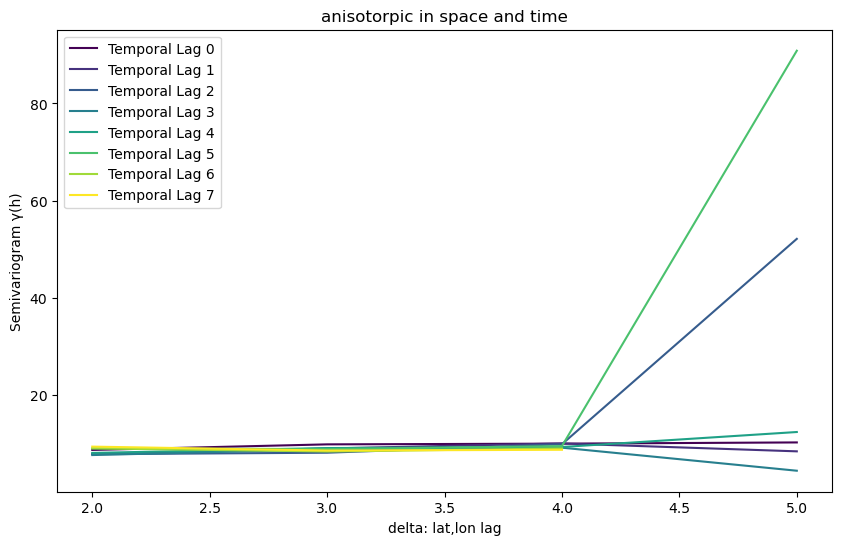

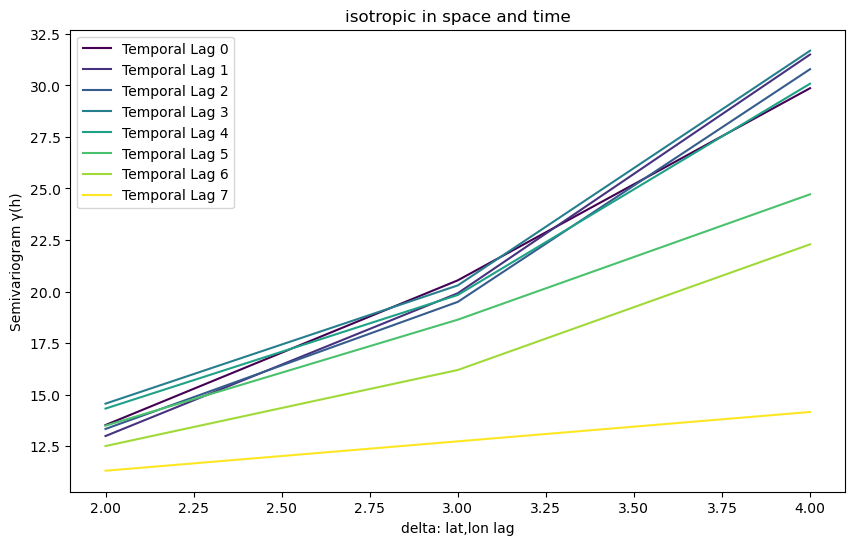

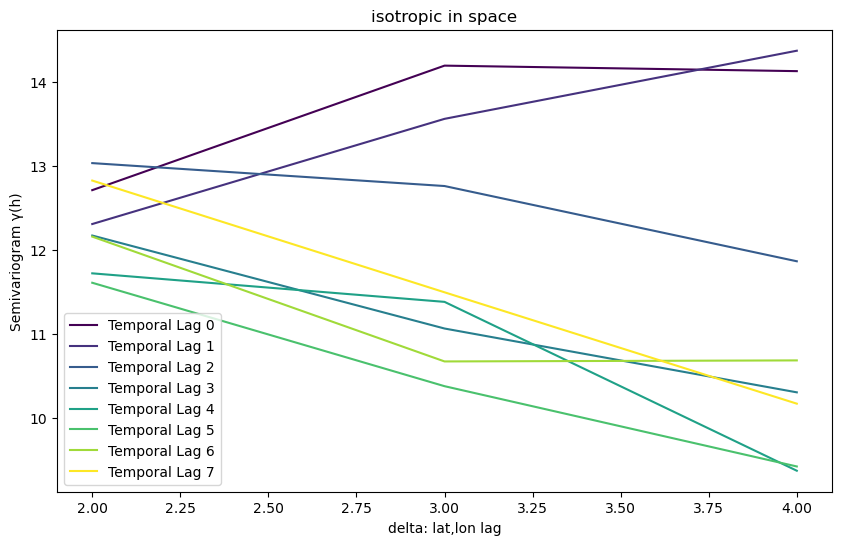

In [99]:
params= torch.tensor( [20, 8.25,8.25, 0.2 , 0.2, 0.5, 5 ]  )
params = [20, 5, 5, 0.5, 0.5, 0.3/5, 4]
tolerance = 0.01
# Define deltas for distance bins
deltas = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.1, 1.3, 1.7, 2.0, 2.2, 2.5, 3.0, 4.0,5,6,8, 10, 12])
# deltas = torch.linspace(-10,10, 21)

colors = plt.cm.viridis(np.linspace(0, 1, 8))  # Color map for the temporal lags

# Plot the empirical and theoretical semivariogram for different temporal lags
plt.figure(figsize=(10, 6))

latitude_lag = 0.2

for temporal_lag in range(8): 
    deltas, emp_gamma = empirical_semivariogram(params, data_ani, deltas,tolerance, latitude_lag,  temporal_lag)
    mask = emp_gamma!=0
    deltas = deltas[mask]
    emp_gamma = emp_gamma[mask]
    
    plt.plot( deltas.clone().detach(), emp_gamma.clone().detach(), color=colors[temporal_lag], label=f'Temporal Lag {temporal_lag}')

plt.xlabel('delta: lat,lon lag')
plt.ylabel('Semivariogram γ(h)')
plt.title('anisotorpic in space and time')
plt.legend()
plt.show()



plt.figure(figsize=(10, 6))
for temporal_lag in range(8): 
    deltas, emp_gamma = empirical_semivariogram(params, data_iso_st, deltas,tolerance, latitude_lag,  temporal_lag)
    mask = emp_gamma!=0
    deltas = deltas[mask]
    emp_gamma = emp_gamma[mask]
    
    plt.plot( deltas.clone().detach(), emp_gamma.clone().detach(), color=colors[temporal_lag], label=f'Temporal Lag {temporal_lag}')

plt.xlabel('delta: lat,lon lag')
plt.ylabel('Semivariogram γ(h)')
plt.title('isotropic in space and time')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
params= torch.tensor( [20, 10, 5, 0.5, 0.5, 0.3/5, 4] )

for temporal_lag in range(8): 
    deltas, emp_gamma = empirical_semivariogram(params, data_iso_space, deltas,tolerance, latitude_lag,  temporal_lag)
    mask = emp_gamma!=0
    deltas = deltas[mask]
    emp_gamma = emp_gamma[mask]
    
    plt.plot( deltas.clone().detach(), emp_gamma.clone().detach(), color=colors[temporal_lag], label=f'Temporal Lag {temporal_lag}')

plt.xlabel('delta: lat,lon lag' )
plt.ylabel('Semivariogram γ(h)')
plt.title('isotropic in space')
plt.legend()
plt.show()

how about latitude slice

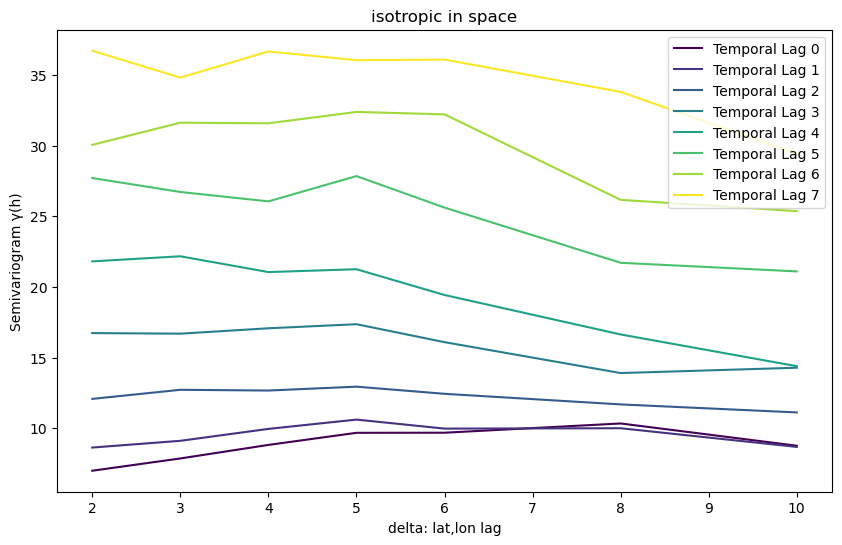

In [43]:
plt.figure(figsize=(10, 6))

latitude_lag = 0.2

for temporal_lag in range(8): 
    deltas, empirical_sem= empirical_semivariogram_slice(params, data_iso_space, deltas,tolerance, latitude_lag,  temporal_lag)
    mask = empirical_sem!=0
    
    deltas = deltas[mask]
    
    tempirical_sem = empirical_sem[mask]
    
    plt.plot( deltas.clone().detach(), tempirical_sem.clone().detach(), color=colors[temporal_lag], label=f'Temporal Lag {temporal_lag}')

plt.xlabel('delta: lat,lon lag' )
plt.ylabel('Semivariogram γ(h)')
plt.title('isotropic in space')
plt.legend()
plt.show()

Simulate isotropic in space model 4 times

params= torch.tensor( [20, 10, 5, 0.5, 0.5, 0.3/5, 4] )

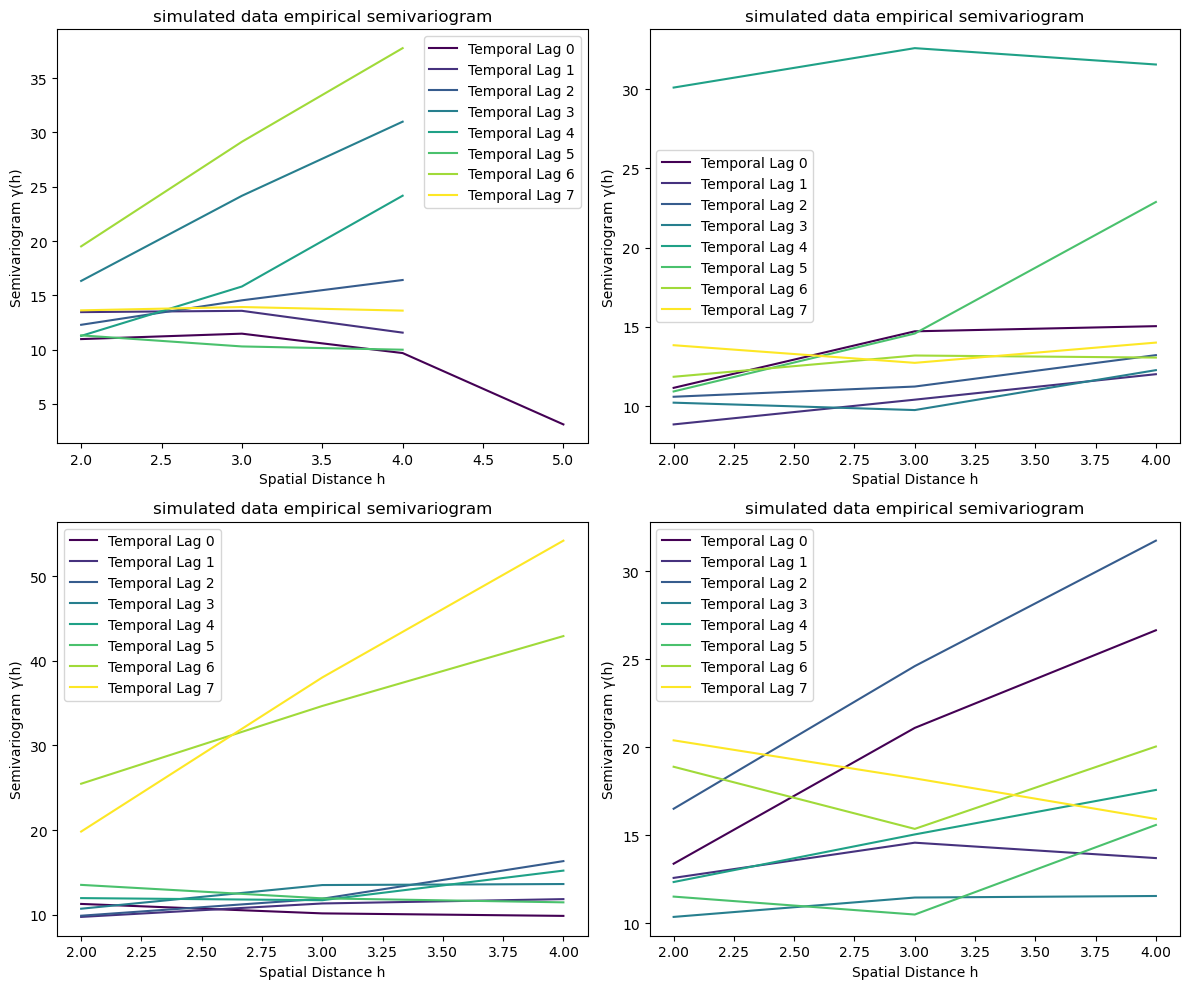

In [100]:
params= torch.tensor( [20, 10, 5, 0.5, 0.5, 0.3/5, 4] )
params = [20, 5, 5, 0.5, 0.5, 0.3/5, 4]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
deltas = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.1, 1.3, 1.7, 2.0, 2.2, 2.5, 3.0, 4.0,5,6,8, 10, 12])

# Iterate over the list of parameter sets
for idx in range(4):
    ax = axs[idx // 2, idx % 2]
    for temporal_lag in range(8):
        data_iso_space = generate_data(10000, params, matern_cov_iso_space)
        deltas, emp_gamma = empirical_semivariogram(params, data_iso_space, deltas, tolerance, latitude_lag, temporal_lag)
        mask = emp_gamma != 0
        deltas = deltas[mask]
        emp_gamma = emp_gamma[mask]
        
        ax.plot(deltas.clone().detach(), emp_gamma.clone().detach(), color=colors[temporal_lag], label=f'Temporal Lag {temporal_lag}')
    
    ax.set_xlabel('Spatial Distance h')
    ax.set_ylabel('Semivariogram γ(h)')
    ax.set_title(f'simulated data empirical semivariogram')
    ax.legend()

plt.tight_layout()
plt.show()

Simulate isotropic in space model 4 times

params = [27.0996, 1.7303, 1.8876, 8.413e-3, -0.1029, 0.1219, 2.73]

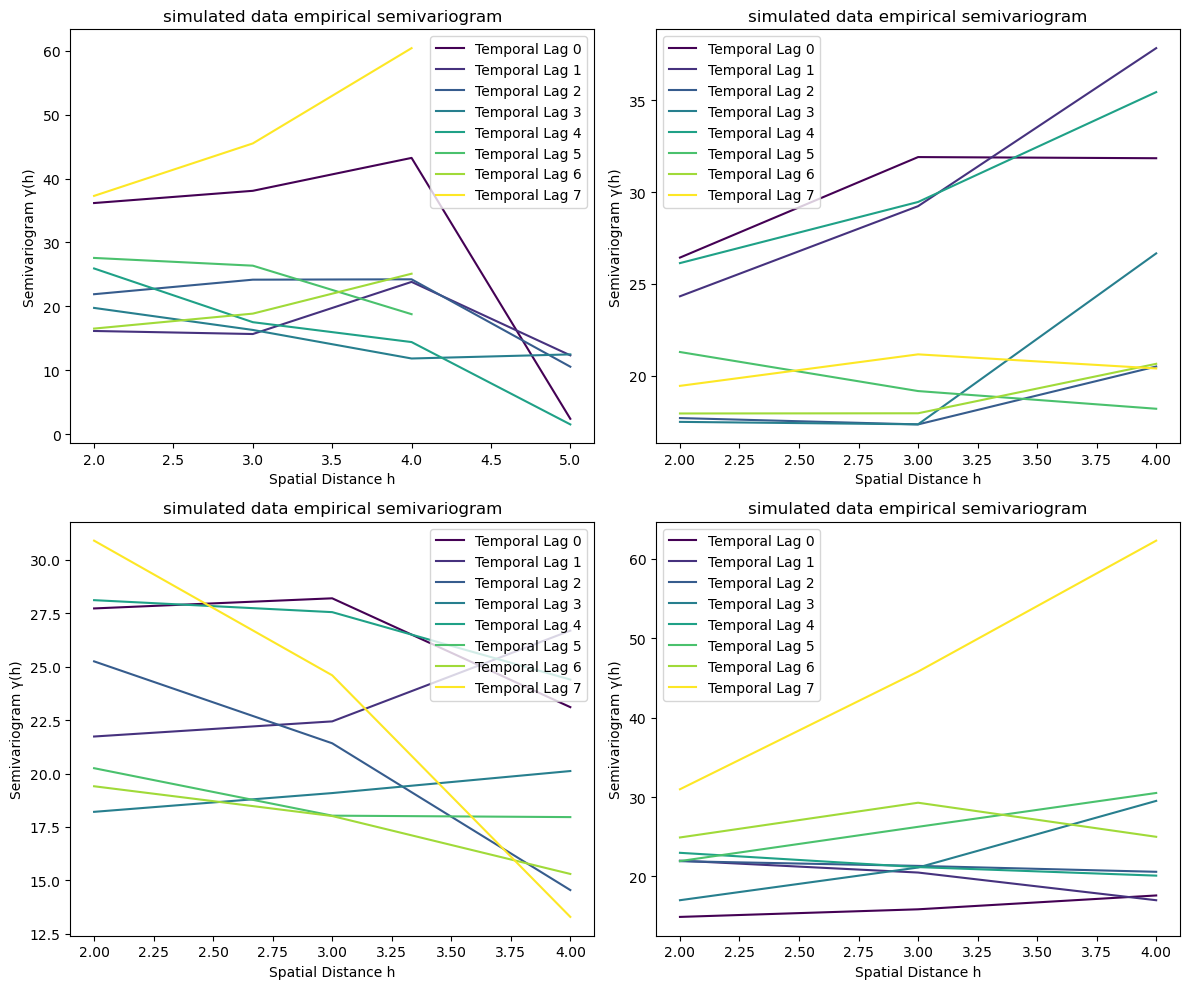

In [101]:
params = [27.0996, 1.7303, 1.8876, 8.413e-3, -0.1029, 0.1219, 2.73]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
deltas = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.1, 1.3, 1.7, 2.0, 2.2, 2.5, 3.0, 4.0,5,6,8, 10, 12])

# Iterate over the list of parameter sets
for idx in range(4):
    ax = axs[idx // 2, idx % 2]
    for temporal_lag in range(8):
        data_iso_space = generate_data(10000, params, matern_cov_ani)
        deltas, emp_gamma = empirical_semivariogram(params, data_iso_space, deltas, tolerance, latitude_lag, temporal_lag)
        mask = emp_gamma != 0
        deltas = deltas[mask]
        emp_gamma = emp_gamma[mask]
        
        ax.plot(deltas.clone().detach(), emp_gamma.clone().detach(), color=colors[temporal_lag], label=f'Temporal Lag {temporal_lag}')
    
    ax.set_xlabel('Spatial Distance h')
    ax.set_ylabel('Semivariogram γ(h)')
    ax.set_title(f'simulated data empirical semivariogram')
    ax.legend()

plt.tight_layout()
plt.show()

day2 codes have to be reviewed from this part

/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/3668564536.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(aggregated_np)  # Assuming `your_data` is a Numpy array
/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/1637770891.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lat = torch.tensor(lat)
/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/1637770891.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lon = torch.tensor(lon)
/var/folders/9p/53hd4c7d2fl193h4jwp194wc

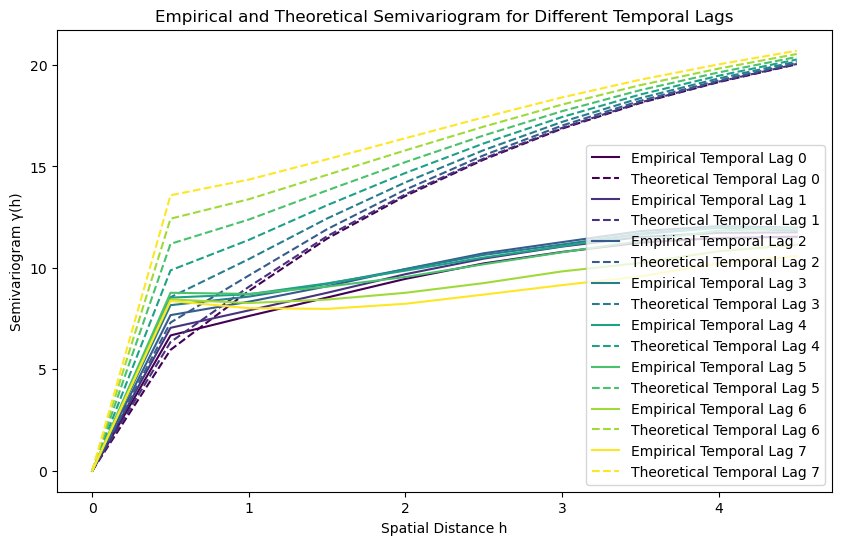

In [69]:

key_for_dict= [8, 16]
analysis_data_map = {}
for i in range(key_for_dict[0],key_for_dict[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)

    tmp = tmp.iloc[ord_mm, :4].to_numpy()
    tmp = torch.from_numpy(tmp).float()  # Convert NumPy to Tensor
    # tmp = tmp.clone().detach().requires_grad_(True)  # Enable gradients
    
    analysis_data_map[key_idx[i]] = tmp

aggregated_data = pd.DataFrame()
for i in range(key_for_dict[0],key_for_dict[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    aggregated_data = pd.concat((aggregated_data, tmp), axis=0)

aggregated_np = aggregated_data.iloc[:, :4].to_numpy()

aggregated_np = torch.from_numpy(aggregated_np).float()  # Convert NumPy to Tensor
# aggregated_np = aggregated_np.clone().detach().requires_grad_(True)  # Enable gradients


instance = kernels.likelihood_function(smooth=0.5, input_map=analysis_data_map, nns_map=nns_map, mm_cond_number=mm_cond_number)


# Example usage
# Replace `your_data` with your actual data
data = torch.tensor(aggregated_np)  # Assuming `your_data` is a Numpy array
max_distance = 5
num_bins = 10

# Define parameters for the theoretical semivariogram
# params = torch.tensor([24.42, 1.92, 1.92, -0.045, 0.237, 3.34])  # Example parameters: sigmasq, range, range_lon, advec, beta, nugget
params = torch.tensor([23.59, 3.83, 3.83, 0.036, 0.277, 2.83  ]) 
params = torch.tensor([24.56, 2.80, 2.80, -0.0138, .301, 2.12  ]) 

# Plot the empirical and theoretical semivariogram for different temporal lags
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 8))  # Generate a color map

for temporal_lag in range(8):
    bins, empirical_gamma = empirical_semivariogram(data, max_distance, num_bins, temporal_lag)
    bins, theoretical_gamma = theoretical_semivariogram(params, data, max_distance, num_bins, temporal_lag)
    
    plt.plot(bins.numpy(), empirical_gamma.numpy(), '-', color=colors[temporal_lag], label=f'Empirical Temporal Lag {temporal_lag}')
    plt.plot(bins.numpy(), theoretical_gamma.numpy(), '--', color=colors[temporal_lag], label=f'Theoretical Temporal Lag {temporal_lag}')

plt.xlabel('Spatial Distance h')
plt.ylabel('Semivariogram γ(h)')
plt.title('Empirical and Theoretical Semivariogram for Different Temporal Lags')
plt.legend()
plt.show()

day3 

/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/4198474054.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(aggregated_np)  # Assuming `your_data` is a Numpy array
/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/2603726844.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lat = torch.tensor(lat)
/var/folders/9p/53hd4c7d2fl193h4jwp194wc0000gn/T/ipykernel_816/2603726844.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lon = torch.tensor(lon)
/var/folders/9p/53hd4c7d2fl193h4jwp194wc

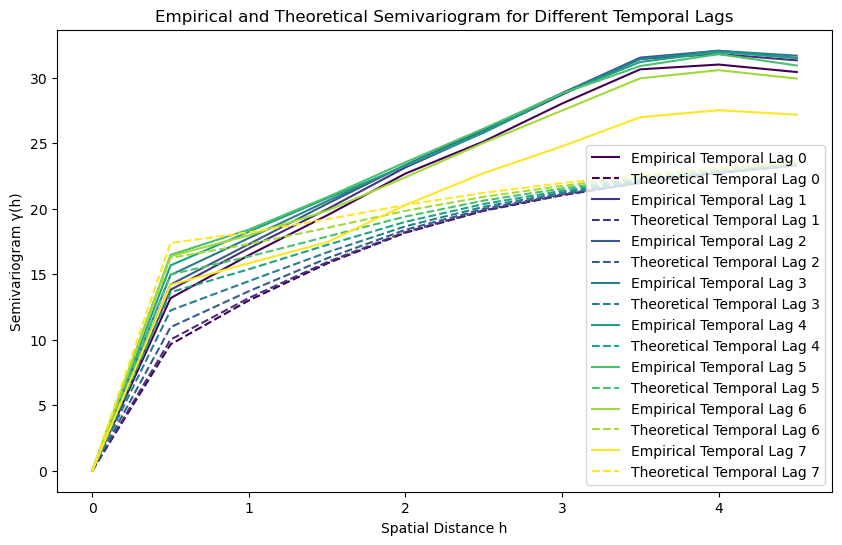

In [65]:
key_for_dict= [16, 24]
analysis_data_map = {}
for i in range(key_for_dict[0],key_for_dict[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)

    tmp = tmp.iloc[ord_mm, :4].to_numpy()
    tmp = torch.from_numpy(tmp).float()  # Convert NumPy to Tensor
    # tmp = tmp.clone().detach().requires_grad_(True)  # Enable gradients
    
    analysis_data_map[key_idx[i]] = tmp

aggregated_data = pd.DataFrame()
for i in range(key_for_dict[0],key_for_dict[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    aggregated_data = pd.concat((aggregated_data, tmp), axis=0)

aggregated_np = aggregated_data.iloc[:, :4].to_numpy()

aggregated_np = torch.from_numpy(aggregated_np).float()  # Convert NumPy to Tensor
# aggregated_np = aggregated_np.clone().detach().requires_grad_(True)  # Enable gradients


instance = kernels.likelihood_function(smooth=0.5, input_map=analysis_data_map, nns_map=nns_map, mm_cond_number=mm_cond_number)


# Example usage
# Replace `your_data` with your actual data
data = torch.tensor(aggregated_np)  # Assuming `your_data` is a Numpy array
max_distance = 5
num_bins = 10

# Define parameters for the theoretical semivariogram
# params = torch.tensor([24.42, 1.92, 1.92, -0.045, 0.237, 3.34])  # Example parameters: sigmasq, range, range_lon, advec, beta, nugget
# params = torch.tensor([23.59, 3.83, 3.83, 0.036, 0.277, 2.83  ]) 
params = torch.tensor([24.91, 1.73, 1.73, -0.056, .259, 3.57 ]) 

# Plot the empirical and theoretical semivariogram for different temporal lags
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 8))  # Generate a color map

for temporal_lag in range(8):
    bins, empirical_gamma = empirical_semivariogram(data, max_distance, num_bins, temporal_lag)
    bins, theoretical_gamma = theoretical_semivariogram(params, data, max_distance, num_bins, temporal_lag)
    
    plt.plot(bins.numpy(), empirical_gamma.numpy(), '-', color=colors[temporal_lag], label=f'Empirical Temporal Lag {temporal_lag}')
    plt.plot(bins.numpy(), theoretical_gamma.numpy(), '--', color=colors[temporal_lag], label=f'Theoretical Temporal Lag {temporal_lag}')

plt.xlabel('Spatial Distance h')
plt.ylabel('Semivariogram γ(h)')
plt.title('Empirical and Theoretical Semivariogram for Different Temporal Lags')
plt.legend()
plt.show()